$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# A measurement-driven greedy algorithm

We have a solution $u$ (actually $u_h$, i.e. the solution of FEM here, but lets just assume it is ground truth here). 
We're given our measurement space $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w := P_{W_m} u$, the projection of $u$ in $W_m$.

This algorithm makes a very simple adjustment to the greedy algorithm - it does the argmax search in the $W_m$ projection. Of course as $n \to m$ there is nothing we can do about $\beta(V_n, W_m) \to 0$.

__Remarks:__
 - __Note that $\dot{\cdot}{\cdot} = \dot{\cdot}{\cdot}_{V_h}$ here.__
 - We can __assume that the $\omega_i$ are orthonormal__ as it is a fixed basis.
 - We store $\dot{\omega_i}{v}$ for each $v\in \cD$, so can we di all projections and inner-products in $\mathbb{R}^m$? And furthermore without the need of a Gram matrix $\dot{\phi_i}{\phi_j}$ to do the projection or orthonormalisation of $\phi_i$?
 - Finally, remember that _we can not know anything about $u$ other than $w :=P_{W_m} u$_, and we abuse notation slightly and also write $w=\dot{\omega_i}{u}$ for the vector in $\mathbb{R}^m$.
 
So what exactly do we do? We have a dictionary $\cD$ of solutions $v(y)$, which we get from generating random points in $y\in\mathbb{R}^{d}$, where $d=16$ in this case, find the field $a(y)$ and then $v(y) = \frac{u_h(a(y))}{\| u_h(a(y)) \|_{V_h}}$ (i.e. we normalise all elements). The first element $\phi_1$ is chosen as 
$$ \phi_1 = {\arg\max}_{v\in \cD} \adot{w}{v}$$
and given our collection $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$,our next choice is
$$ \phi_{n+1} = {\arg\max}_{v\in \cD} \adot{w}{P_{V_n^\perp} v}$$

So first we note that
$$
\dot{w}{P_{V_n^\perp} v}
= \dot{w}{v} 
- \dot{w}{P_{V_n} v}
$$
Evidently given $\dot{\omega_i}{v}$ is stored already, we can compute $\dot{w}{v}$ as a dot product in $\mathbb{R}^m$

Can the same be said for $\dot{w}{P_{V_n} v}$ without needing to compute $\dot{\phi_i}{v}$ and $\dot{\phi_i}{\phi_j}$? Well, that is to be checked shortly.

Now, we need to derive the further dot products in terms of a $W_m$ or $\mathbb{R}^m$ dot product. I'm reasonably sure it can be done without the need of the Gram matrix $\dot{\phi_i}{\phi_j}$ but I need to check.

# Algorithm 2: Another measurement based greedy basis construction

This was tried earlier in the year and seemed to perform remarkably well...

In this algorithm the first member is chosen as
$$
\phi_1 = \mathrm{argmax}_{v\in\mathcal{D}} \adot{w}{v}
$$
and the $(n+1)$-th member is
$$
\phi_{n+1} = \mathrm{argmax}_{v\in\mathcal{D}} \adot{w}{P_{V_n^\perp} P_{W_m} v}
$$
Which is interesting.

Analysis of either of these algorithms will be interesting.


In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Generate the solution $u$ that we want to approximate

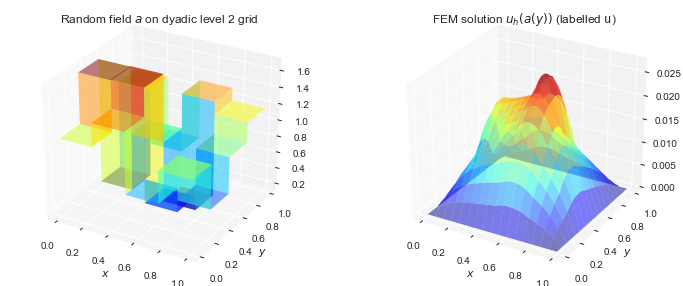

In [2]:
fem_div = 7

a_bar = 1.0
c = 0.9
field_div = 2
side_n = 2**field_div

np.random.seed(3)
point_gen = pat.MonteCarlo(d=side_n*side_n, n=1, lims=[-1, 1])
a = pat.PWConstantSqDyadicL2(a_bar + c * point_gen.points[0,:].reshape([side_n, side_n]), div=field_div)
fem = pat.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

u = fem.u

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(1, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u}$)')
plt.show()

### Generate the basis $W_m$ of randomly placed local averages

[]

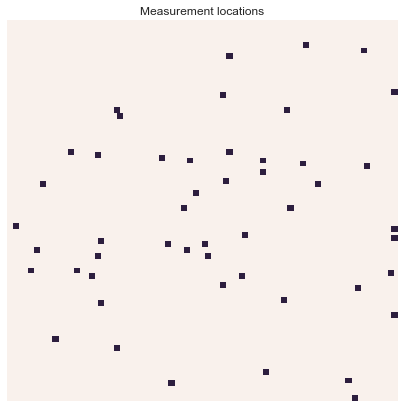

In [3]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
local_width = 2
m = 50

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm, Wloc = pat.make_pw_local_avg_random_basis(m=m, div=fem_div, width=local_width, return_map=True)
Wm = Wm.orthonormalise()

fig, ax = plt.subplots(figsize=(7,7))     
sns.heatmap(Wloc.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Measurement locations')
#plt.savefig('ddgrb_measurements.pdf')
plt.plot()

### Generate the dictionary of random snapshots

In [4]:
N = int(1e3)
np.random.seed(1)
dict_basis, dict_fields = pat.make_pw_reduced_basis(N, field_div, fem_div, a_bar=a_bar, c=c, f=1.0, verbose=False)
dictionary = dict_basis.vecs

In [5]:
w = Wm.dot(u)

mbg = pat.MeasBasedGreedy(dictionary, w, Wm, Vn=pat.PWBasis(), verbose=True, remove=False)
mbg.construct_to_n(m)

#mbgp = pat.MeasBasedGreedyPerp(dictionary, w, Wm, Vn=pat.PWBasis(), verbose=True, remove=True)
#mbgp.construct_to_n(m)

Vn_sin = pat.make_pw_sin_basis(div=fem_div)
 

i 	 Sel. criteria
2 : 	 0.0038109287820600715
3 : 	 0.0033279874058015223
4 : 	 0.002539952065362072
5 : 	 0.0019099450098574503
6 : 	 0.0015972771687416752
7 : 	 0.001138052084693126


KeyboardInterrupt: 

In [19]:
ns = range(2, m+1, 2)

bases = [Vn_sin, Vn_red, mbg.Vn]#, mbgp.Vn]
basis_labels = ['Sinusoid basis', 'Reduced basis', 'Meas based greedy algo N=5e3']#, 'Meas based greed algo II N=5e3']

#stats = np.zeros([6, len(bases), len(ns)])

for j, Vn_big in enumerate(bases):
    print('Reconstructions for basis: ' + basis_labels[j])
    for i, n in enumerate(ns):
        
        Vn = Vn_big.subspace(slice(0,n))

        u_p_v = Vn.project(u)
        BP = pat.BasisPair(Wm, Vn.orthonormalise())
        #FB = BP.make_favorable_basis()
        u_star, v_star, w_p, v_w_p, cond = BP.measure_and_reconstruct(u)

        stats[0, j, i] = (u-u_star).norm()
        stats[1, j, i] = (u_star - v_star).norm()
        stats[2, j, i] = BP.beta()
        stats[3, j, i] = cond
        stats[4, j, i] = (u - u_p_v).norm()

Reconstructions for basis: Sinusoid basis
Reconstructions for basis: Reduced basis
Reconstructions for basis: Meas based greedy algo N=5e3


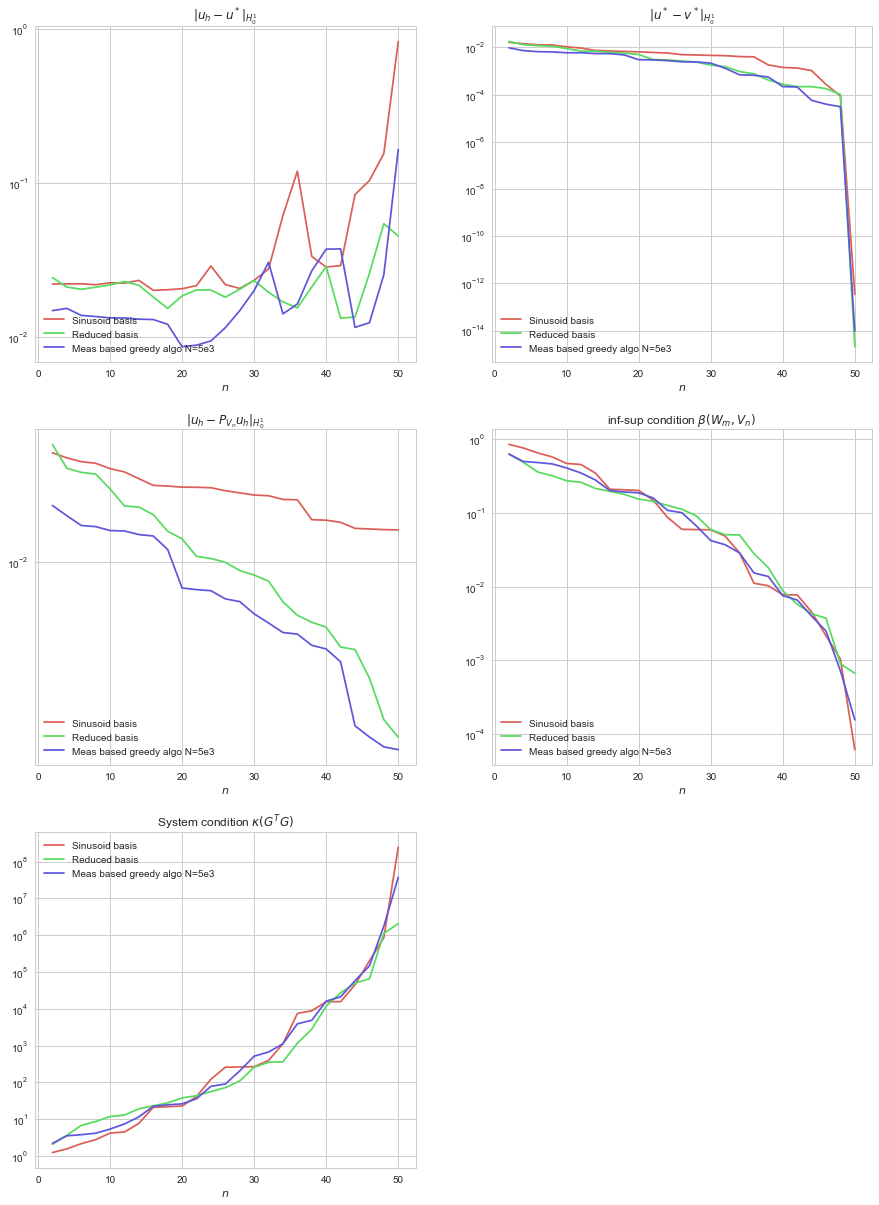

In [20]:
sns.set_palette('hls', len(basis_labels))
sns.set_style('whitegrid')

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for j, basis_label in enumerate(basis_labels):

    axs[0].plot(ns, stats[0, j, :], label=basis_label)
    axs[0].legend(loc=3)
    axs[1].plot(ns, stats[1, j, :], label=basis_label)
    axs[1].legend(loc=3)
    axs[2].plot(ns, stats[4, j, :], label=basis_label)
    axs[2].legend(loc=3)
    axs[3].plot(ns, stats[2, j, :], label=basis_label)
    axs[3].legend(loc=3)
    axs[4].plot(ns, stats[3, j, :], label=basis_label)
    axs[4].legend(loc=2)

    
plt.show()

Note for later:

 
 .
 
 
 .
 
 .
 
 .
 
 .
 
 .
 
 .
 
 .
 
 .
 
 .
.


.

.

.

.

.

.











Now, certainly in the case of orthonormal $\phi_i$, for any $v\in V_h$
$$
 P_{V_n} v = \sum_{i=1}^n c_i \phi_i
$$
where if $\bc = (c_1,\ldots,c_n)$ and $\bv_{W_m} = (\dot{\omega_1}{v},\ldots,\dot{\omega_m}{v})$, then it is the solution of
$$
\bG^T \bv_{W_m} = \bG^T\bG \bc
$$
(But this works with non-orthonormal $\phi_i$ as well no? Need to check)

Also: 

### Removal property - this algorithms do not rule out $v$ if $v\in V_n$
In the first algorithm from the we have that the $\mathrm{argmax}$ step ignores anything in $V_n$, as the perpindicular is $0$. Here however we have no such guarantee, so we must remove elements from the dictionary as we construct the basis. What does this mean? What about if there are two $\phi_0$ and $\phi_1$ that are very close to each other in the dictionary and one gets chosen for the greedy basis...?